In [1]:
!echo $CONDA_PREFIX

/home/ubuntu/miniconda3/envs/jupyter_launch


In [2]:
import tensorflow as tf
from tensorflow import keras as K

import nibabel as nib
import numpy as np
import os
import datetime
    
import matplotlib.pyplot as plt

#import warnings
#warnings.filterwarnings("ignore")

In [3]:
def get_mkl_enabled_flag():

    mkl_enabled = False
    major_version = int(tf.__version__.split(".")[0])
    minor_version = int(tf.__version__.split(".")[1])
    if major_version >= 2:
        if minor_version < 5:
            from tensorflow.python import _pywrap_util_port
        elif minor_version >= 9:

            from tensorflow.python.util import _pywrap_util_port
            onednn_enabled = int(os.environ.get('TF_ENABLE_ONEDNN_OPTS', '1'))

        else:
            from tensorflow.python.util import _pywrap_util_port
            onednn_enabled = int(os.environ.get('TF_ENABLE_ONEDNN_OPTS', '0'))
        mkl_enabled = _pywrap_util_port.IsMklEnabled() or (onednn_enabled == 1)
    else:
        mkl_enabled = tf.pywrap_tensorflow.IsMklEnabled()
    return mkl_enabled

print ("We are using Tensorflow version", tf.__version__)
print("MKL enabled :", get_mkl_enabled_flag())

We are using Tensorflow version 2.8.2
MKL enabled : True


In [4]:
!pwd

/home/ubuntu/BraTS_from_Cloud_to_Edge_Inferencing


## Define the settings

In [5]:
DATA_PATH="/home/ubuntu/BraTS_from_Cloud_to_Edge_Inferencing/data/Task01_BrainTumour/"

TRAIN_TEST_SPLIT = 0.80
VALIDATE_TEST_SPLIT = 0.50

BATCH_SIZE_TRAIN = 8
BATCH_SIZE_VALIDATE = 4
BATCH_SIZE_TEST = 1

TILE_HEIGHT = 128
TILE_WIDTH = 128
TILE_DEPTH = 128
NUMBER_INPUT_CHANNELS = 1

CROP_DIM = (128,128,128,1)
#CROP_DIM = (144,144,144,1)

NUMBER_OUTPUT_CLASSES = 1

RANDOM_SEED = 64

## Define a data loader

We'll use `tf.data` to define a way to load the BraTS dataset at runtime whenever a new batch of 3D images and masks are requested.

In [6]:
class DatasetGenerator:
        
    def __init__(self, 
                 data_path = DATA_PATH,
                 train_test_split = TRAIN_TEST_SPLIT,
                 validate_test_split = VALIDATE_TEST_SPLIT,
                 batch_size_train = BATCH_SIZE_TRAIN,
                 batch_size_validate = BATCH_SIZE_VALIDATE,
                 batch_size_test = BATCH_SIZE_TEST,
                 crop_dim = CROP_DIM,
                 number_output_classes = NUMBER_OUTPUT_CLASSES,
                 random_seed = RANDOM_SEED
                ):
        
        self.data_path = data_path
        self.train_test_split = train_test_split
        self.validate_test_split = validate_test_split
        self.batch_size_train = batch_size_train
        self.batch_size_validate = batch_size_validate
        self.batch_size_test = batch_size_test
        self.crop_dim = crop_dim
        self.number_output_classes = number_output_classes
        self.random_seed = random_seed
        
        self.create_file_list()
        
#        self.ds_train, self.ds_val, self.ds_test = self.get_dataset()


    def create_file_list(self):
        """
        Get list of the files from the BraTS raw data
        Split into training and testing sets.
        """
        import os
        import json
        
        json_filename = os.path.join(self.data_path, "dataset.json")

        try:
            with open(json_filename, "r") as fp:
                experiment_data = json.load(fp)
        except IOError as e:
            print("File {} doesn't exist. It should be part of the "
                  "Decathlon directory".format(json_filename))

        self.output_channels = experiment_data["labels"]
        self.input_channels = experiment_data["modality"]
        self.description = experiment_data["description"]
        self.name = experiment_data["name"]
        self.release = experiment_data["release"]
        self.license = experiment_data["licence"]
        self.reference = experiment_data["reference"]
        self.tensor_image_size = experiment_data["tensorImageSize"]
        self.num_files = experiment_data["numTraining"]
        
        """
        Create a dictionary of tuples with image filename and label filename
        """
        self.filenames = {}
        for idx in range(self.num_files):
            self.filenames[idx] = [os.path.join(self.data_path,
                                              experiment_data["training"][idx]["image"]),
                                    os.path.join(self.data_path,
                                              experiment_data["training"][idx]["label"])]
            
        
    def print_info(self):
        """
        Print the dataset information
        """

        print("="*30)
        print("Dataset name:        ", self.name)
        print("Dataset description: ", self.description)
        print("Tensor image size:   ", self.tensor_image_size)
        print("Dataset release:     ", self.release)
        print("Dataset reference:   ", self.reference)
        print("Input channels:      ", self.input_channels)
        print("Output labels:       ", self.output_channels)
        print("Dataset license:     ", self.license)
        print("="*30)
        

In [7]:
brats_datafiles = DatasetGenerator(DATA_PATH)
brats_datafiles.print_info()

Dataset name:         BRATS
Dataset description:  Gliomas segmentation tumour and oedema in on brain images
Tensor image size:    4D
Dataset release:      2.0 04/05/2018
Dataset reference:    https://www.med.upenn.edu/sbia/brats2017.html
Input channels:       {'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'}
Output labels:        {'0': 'background', '1': 'edema', '2': 'non-enhancing tumor', '3': 'enhancing tumour'}
Dataset license:      CC-BY-SA 4.0


## Data preprocessing

Here we preprocess the 3D MRI scans. We'll normalize the images, crop the images, and do random flips/rotations.

In [8]:
def z_normalize_img(img):
    """
    Normalize the image so that the mean value for each image
    is 0 and the standard deviation is 1.
    """
    for channel in range(img.shape[-1]):

        img_temp = img[..., channel]
        img_temp = (img_temp - np.mean(img_temp)) / np.std(img_temp)

        img[..., channel] = img_temp

    return img
    
def crop(img, msk, randomize):
        """
        Randomly crop the image and mask
        """

        slices = []
        
        # Do we randomize?
        is_random = randomize and np.random.rand() > 0.5

        for idx in range(len(img.shape)-1):  # Go through each dimension

            crop_len = brats_datafiles.crop_dim[idx]
            img_len = img.shape[idx]

            start = (img_len-crop_len)//2

            ratio_crop = 0.20  # Crop up this this % of pixels for offset
            # Number of pixels to offset crop in this dimension
            offset = int(np.floor(start*ratio_crop))

            if offset > 0:
                if is_random:
                    start += np.random.choice(range(-offset, offset))
                    if ((start + crop_len) > img_len):  # Don't fall off the image
                        start = (img_len-crop_len)//2
            else:
                start = 0

            slices.append(slice(start, start+crop_len))

        return img[tuple(slices)], msk[tuple(slices)]
    
def augment_data(img, msk, crop_dim):
    """
    Data augmentation
    Flip image and mask. Rotate image and mask.
    """
    
    # Determine if axes are equal and can be rotated
    # If the axes aren't equal then we can't rotate them.
    equal_dim_axis = []
    for idx in range(0, len(crop_dim)):
        for jdx in range(idx+1, len(crop_dim)):
            if crop_dim[idx] == crop_dim[jdx]:
                equal_dim_axis.append([idx, jdx])  # Valid rotation axes
    dim_to_rotate = equal_dim_axis

    if np.random.rand() > 0.5:
        # Random 0,1 (axes to flip)
        ax = np.random.choice(np.arange(len(crop_dim)-1))
        img = np.flip(img, ax)
        msk = np.flip(msk, ax)

    elif (len(dim_to_rotate) > 0) and (np.random.rand() > 0.5):
        rot = np.random.choice([1, 2, 3])  # 90, 180, or 270 degrees

        # This will choose the axes to rotate
        # Axes must be equal in size
        random_axis = dim_to_rotate[np.random.choice(len(dim_to_rotate))]
        
        img = np.rot90(img, rot, axes=random_axis)  # Rotate axes 0 and 1
        msk = np.rot90(msk, rot, axes=random_axis)  # Rotate axes 0 and 1

    return img, msk
    
def read_nifti_file(idx, crop_dim, randomize=False):
    """
    Read Nifti file
    """
    
    idx = idx.numpy()
    img_file = brats_datafiles.filenames[idx][0]
    msk_file = brats_datafiles.filenames[idx][1]
    
    img = np.array(nib.load(img_file).dataobj)
    
    img = np.rot90(img[...,[0]]) # Just take the FLAIR channel (0)
    
    msk = np.rot90(np.array(nib.load(msk_file).dataobj))

    """
    "labels": {
         "0": "background",
         "1": "edema",
         "2": "non-enhancing tumor",
         "3": "enhancing tumour"}
     """
    # Combine all masks but background
    if brats_datafiles.number_output_classes == 1:
        msk[msk > 0] = 1.0
        msk = np.expand_dims(msk, -1)
    else:
        msk_temp = np.zeros(list(msk.shape) + [brats_datafiles.number_output_classes])
        for channel in range(brats_datafiles.number_output_classes):
            msk_temp[msk == channel, channel] = 1.0
        msk = msk_temp
    
#    imgFilename = (os.path.basename(brats_datafiles.filenames[idx][0])).split(".nii.gz")[0]
    
    # Crop
    img, msk = crop(img, msk, randomize)
    
    # Normalize
    img = z_normalize_img(img)
    
    # Randomly rotate
    if randomize:
        img, msk = augment_data(img, msk, crop_dim)
    
    return img, msk
    

## tf.data

Define the training, testing, and validation data loaders.

In [9]:
num_files = brats_datafiles.num_files
num_train = int(num_files * brats_datafiles.train_test_split)
num_val_test = num_files - num_train

ds = tf.data.Dataset.range(num_files).shuffle(num_files, brats_datafiles.random_seed) # Shuffle the dataset

ds_train = ds.take(num_train)
ds_val_test = ds.skip(num_train)
ds_val = ds_val_test.take(int(num_val_test * brats_datafiles.validate_test_split))
ds_test = ds_val_test.skip(int(num_val_test * brats_datafiles.validate_test_split))

ds_train = ds_train.map(lambda x: tf.py_function(read_nifti_file, [x, brats_datafiles.crop_dim, True], [tf.float32, tf.float32]), num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(lambda x: tf.py_function(read_nifti_file, [x, brats_datafiles.crop_dim, False], [tf.float32, tf.float32]), num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(lambda x: tf.py_function(read_nifti_file, [x, brats_datafiles.crop_dim, False], [tf.float32, tf.float32]), num_parallel_calls=tf.data.AUTOTUNE)

ds_train = ds_train.repeat()
ds_train = ds_train.batch(brats_datafiles.batch_size_train)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.batch(brats_datafiles.batch_size_validate)
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.batch(brats_datafiles.batch_size_test)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

2022-09-01 16:38:25.122434: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-01 16:38:25.123646: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Plot some data samples

Plots the MRI and Tumor Masks from a few data samples.

In [10]:
def plot_images(ds, slice_num=None):
    """
    Plot images from dataset
    """
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15,30))
    
    num_cols=2
    
    msk_channel=0
    img_channel=0 
    
    for img, msk in ds.take(1):
        batch_size = img.shape[0]
        if slice_num == None:
            slice_num = int(img.shape[3] / 2)

        for idx in range(batch_size):
            plt.subplot(batch_size, num_cols, idx*num_cols + 1)
            plt.imshow(img[idx, :, :, slice_num, img_channel], cmap="gray")
            plt.title(f"MRI {brats_datafiles.input_channels[str(img_channel)]}", fontsize=18)
            plt.subplot(batch_size, num_cols, idx*num_cols + 2)
            plt.imshow(msk[idx, :, :, slice_num, msk_channel], cmap="gray")
            plt.title("Tumor", fontsize=18)
    
    plt.show()
    
    print(f"Mean pixel value of image = {np.mean(img[0,:,:,:,0])}")

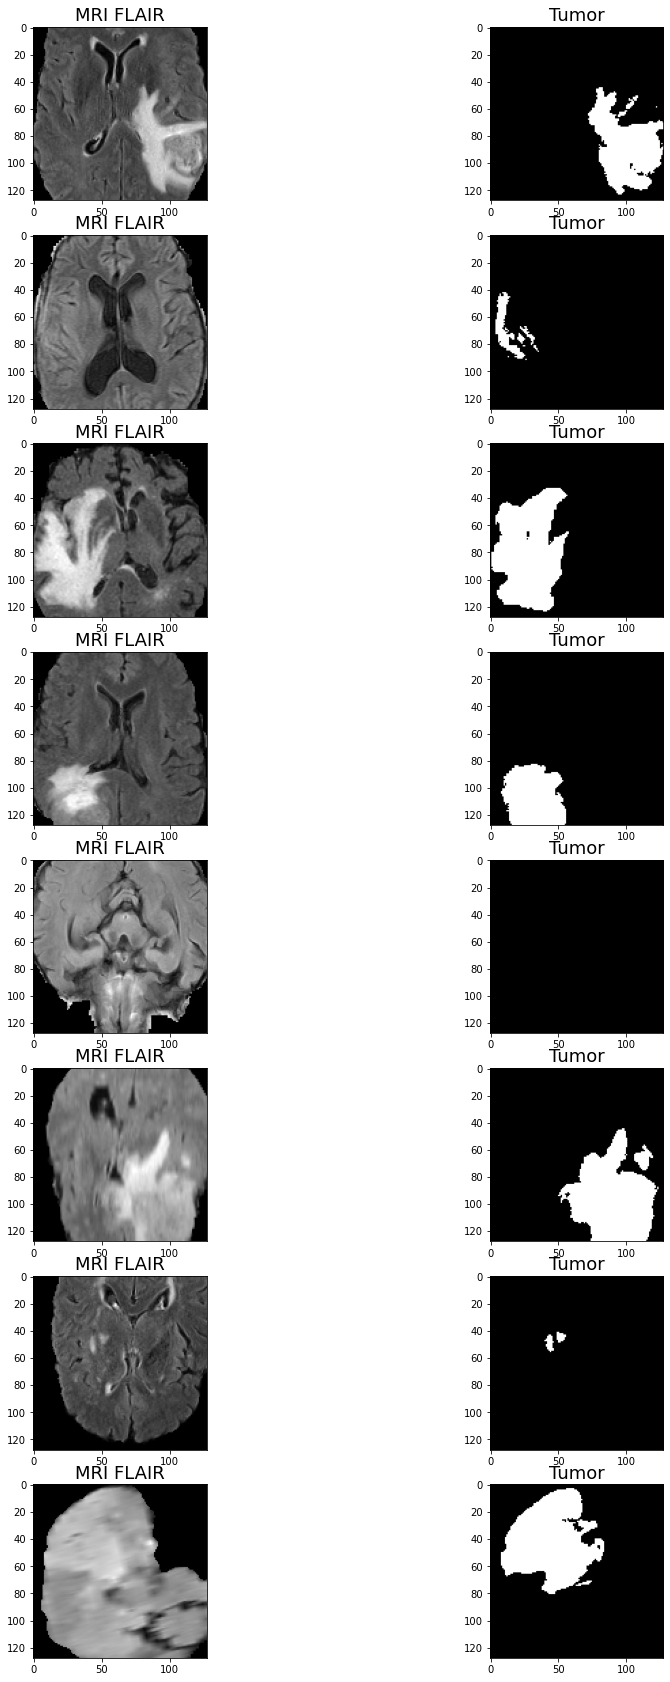

Mean pixel value of image = 7.578637450933456e-08


In [11]:
%matplotlib inline
plot_images(ds_train)

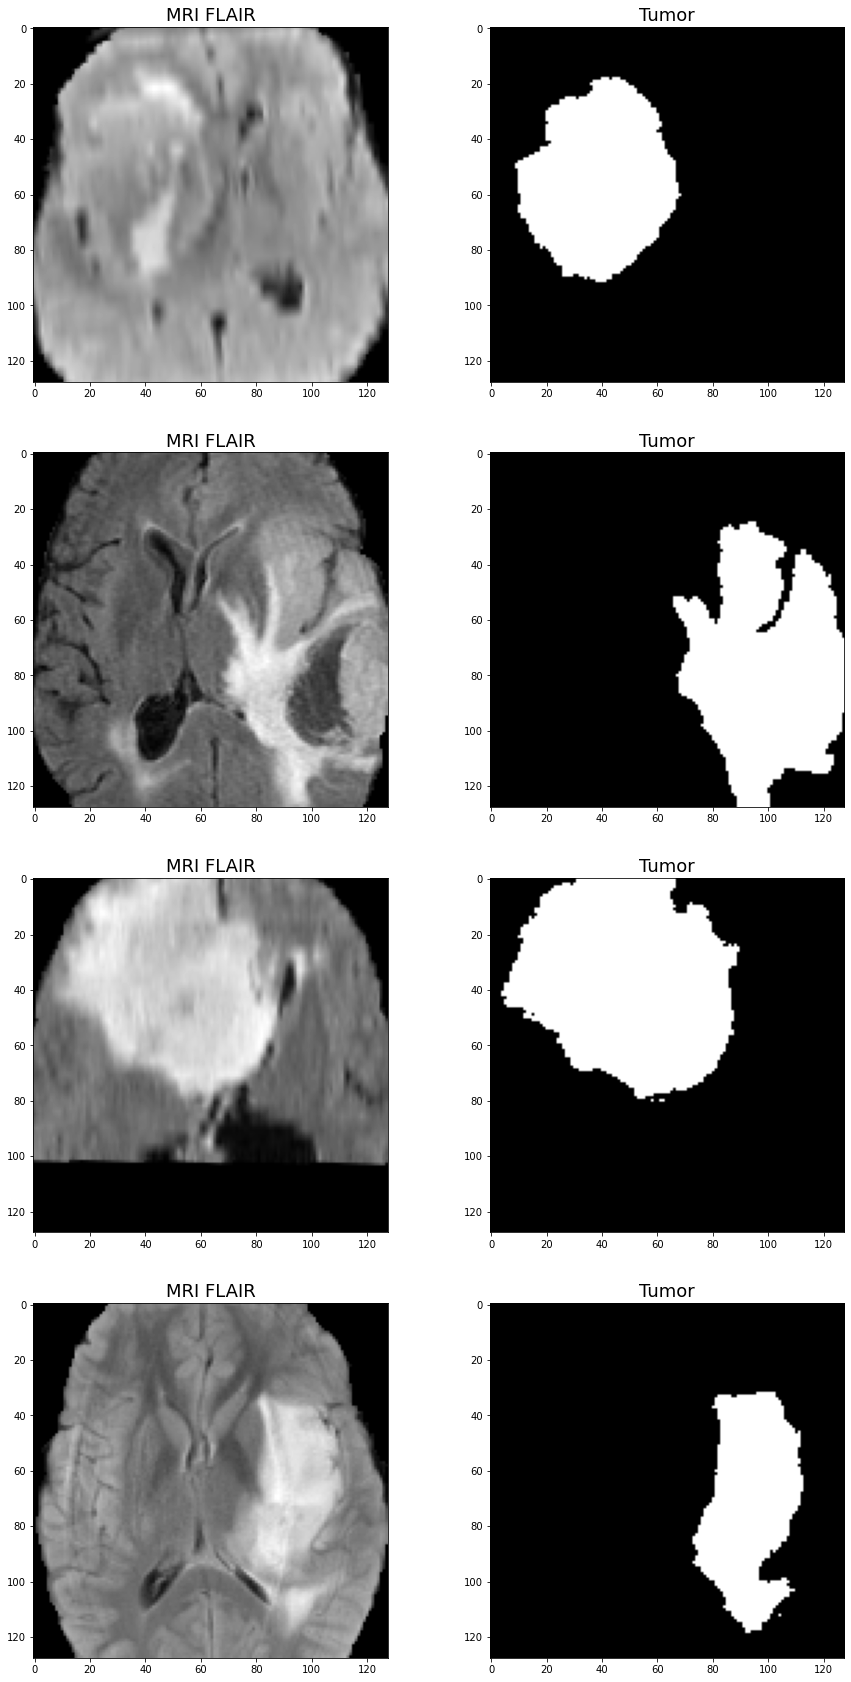

Mean pixel value of image = -6.577465683221817e-08


In [12]:
%matplotlib inline
plot_images(ds_val)

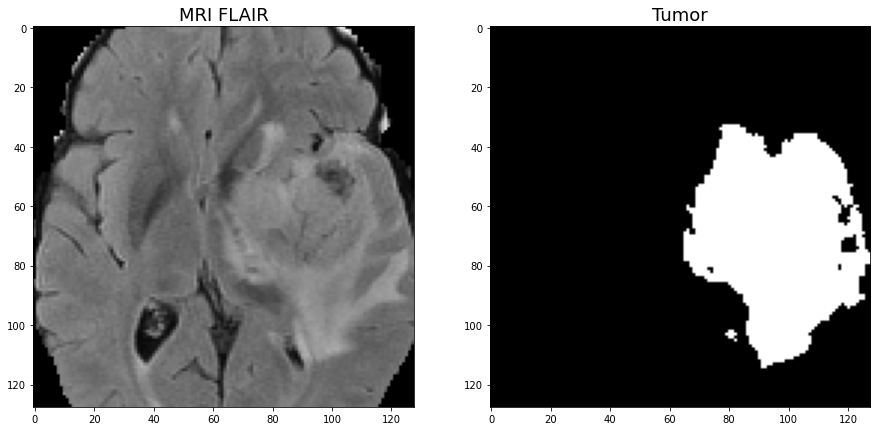

Mean pixel value of image = 3.132736310362816e-07


In [13]:
%matplotlib inline
plot_images(ds_test)